In [88]:
import time
import pandas as pd
import requests
import re
import matplotlib.pyplot as plt
import seaborn as sns

from selenium import webdriver
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.common.by import By
from webdriver_manager.chrome import ChromeDriverManager
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.common.keys import Keys
from bs4 import BeautifulSoup, element

In [84]:
def main_fun(city, page_num):
    # Get the HTML from the page
    url = 'https://www.otodom.pl'
    res = requests.get(url)
    soup = BeautifulSoup(res.text, 'html.parser')
    # search input
    key = city
    driver = webdriver.Chrome(service=Service(ChromeDriverManager().install()))
    driver.get(url)
    time.sleep(2)
    # full screen window 
    driver.maximize_window()
    #cookie click
    cookie_click = driver.find_element(By.XPATH, '//*[@id="onetrust-accept-btn-handler"]')
    cookie_click.click()
    time.sleep(2)
    #search bar click
    search_bar = driver.find_element(By.XPATH, '//*[@id="location"]/div[2]')
    search_bar.click()
    time.sleep(2)
    #search entry
    search_entry = driver.find_element(By.XPATH, '//*[@id="location-picker-input"]')
    search_entry.send_keys(key)
    time.sleep(2)
    #search select
    search_select = driver.find_element(By.XPATH, '//*[@id="__next"]/main/section/div/div/form/div/div[1]/div[3]/div/div[1]/div/div[2]/ul/li[1]/label[1]')
    search_select.click()
    time.sleep(2)
    #search button press
    search_button = driver.find_element(By.XPATH, '//*[@id="search-form-submit"]')
    search_button.click()
    time.sleep(5)
    # getting apartments data    
    url = driver.current_url 
    res = requests.get(url)
    time.sleep(2)
    # 72 per page    
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div').click()
    time.sleep(2)
    driver.find_element(By.XPATH, '/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/div/div/div/div[2]/div/div[4]').click() 
    time.sleep(3)
    df_otodom = pd.DataFrame()

    j = 3

    for i in range(0, page_num):
        if page_num == 1:
            # scroll to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            df_otodom = pd.DataFrame()
            # getting apartments data
            url = driver.current_url
            res = requests.get(url)
            time.sleep(3)
            # scroll to bottom
            driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
            time.sleep(2)
            soup = BeautifulSoup(driver.page_source, 'html.parser')
            apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
            apt: element.Tag
            apartments = list()
            for apt in apartment:
                try:
                    apartments.append({
                        'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                        'city': key,
                        'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                        'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                        'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                        'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                        'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                    })
                except:
                    pass
            df = pd.DataFrame(apartments)
            # df link column to list
            links = df['link'].tolist()
            good_links = list()
            for i in range(len(links)):
                url = links[i]
                prefix = 'https://www.otodom.pl'
                suffix = url.split('/oferta/')[-1]
                result = prefix + '/oferta/' + suffix
                good_links.append(result)

            # replace df link column with good_links
            df['link'] = good_links
            
            additions = list()
            for x in range(len(df['link'])):
                url = df['link'][x]
                res = requests.get(url)
                soup = BeautifulSoup(res.text, 'html.parser')
                try:
                    forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                except:
                    forma_wlasnosci = None
                    
                try:
                    stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                except:
                    stan_wykonczenia = None
                    
                try:
                    pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                except:
                    pietro = None
                    
                try:
                    balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                except:
                    balkon = None
                    
                try:
                    czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                except:
                    czynsz = None
                
                try:
                    parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                except:
                    parking = None
                    
                try:
                    ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                except:
                    ogrzewanie = None
                
                additions.append({
                'forma_wlasnosci': forma_wlasnosci,
                'stan_wykonczenia': stan_wykonczenia,
                'pietro': pietro,
                'balkon': balkon,
                'czynsz': czynsz,
                'parking': parking,
                'ogrzewanie': ogrzewanie
                })
            df = df.join(pd.DataFrame(additions))
            df_otodom = df_otodom.append(df)
        else:
               # scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                # getting apartments data
                url = driver.current_url
                res = requests.get(url)
                time.sleep(3)
                ##scroll to bottom
                driver.execute_script("window.scrollTo(0, document.body.scrollHeight);")
                time.sleep(2)
                soup = BeautifulSoup(driver.page_source, 'html.parser')
                apartment = soup.find_all('li', {'class': 'css-iq9jxc e1n6ljqa1'})
                apt: element.Tag
                apartments = list()
                for apt in apartment:
                    try:
                        apartments.append({
                            'name': apt.find('h3', {'class': 'css-1mmyqk7 e1n6ljqa6'}).text,
                            'city': key,
                            'price': apt.find('span', {'class': 'css-1ntk0hg ei6hyam1'}).text,
                            'rooms': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[2].get_text(),
                            'area': (apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[3].get_text()),
                            'price_per_m2': apt.find('div', {'class': 'e1n6ljqa19 css-6vtodn ei6hyam0'}).find_all('span')[1].get_text(),
                            'link': url + apt.find('a', {'class': 'css-1up0y1q e1n6ljqa16'}).get('href')
                        })
                    except:
                        pass
                df = pd.DataFrame(apartments)
                
                links = df['link'].tolist()
                good_links = list()
                for i in range(len(links)):
                    url = links[i]
                    prefix = 'https://www.otodom.pl'
                    suffix = url.split('/oferta/')[-1]
                    result = prefix + '/oferta/' + suffix
                    good_links.append(result)

                # replace df link column with good_links
                df['link'] = good_links
                
                additions = list()
                for x in range(len(df['link'])):
                    url = df['link'][x]
                    res = requests.get(url)
                    soup = BeautifulSoup(res.text, 'html.parser')
                    try:
                        forma_wlasnosci = soup.find('div', {'aria-label': 'Forma własności'}).find_all('div')[3].text
                    except:
                        forma_wlasnosci = None
                        
                    try:
                        stan_wykonczenia = soup.find('div', {'aria-label': 'Stan wykończenia'}).find_all('div')[3].text
                    except:
                        stan_wykonczenia = None
                        
                    try:
                        pietro = soup.find('div', {'aria-label': 'Piętro'}).find_all('div')[3].text
                    except:
                        pietro = None
                        
                    try:
                        balkon = soup.find('div', {'aria-label': 'Balkon / ogród / taras'}).find_all('div')[3].text
                    except:
                        balkon = None
                        
                    try:
                        czynsz = soup.find('div', {'aria-label': 'Czynsz'}).find_all('div')[3].text
                    except:
                        czynsz = None
                    
                    try:
                        parking = soup.find('div', {'aria-label': 'Miejsce parkingowe'}).find_all('div')[3].text
                    except:
                        parking = None
                        
                    try:
                        ogrzewanie = soup.find('div', {'aria-label': 'Ogrzewanie'}).find_all('div')[3].text
                    except:
                        ogrzewanie = None
                    
                    additions.append({
                    'forma_wlasnosci': forma_wlasnosci,
                    'stan_wykonczenia': stan_wykonczenia,
                    'pietro': pietro,
                    'balkon': balkon,
                    'czynsz': czynsz,
                    'parking': parking,
                    'ogrzewanie': ogrzewanie
                    })
                df = df.join(pd.DataFrame(additions))
                df_otodom = df_otodom.append(df)

                # scroll to top                                   
                driver.execute_script("window.scrollTo(document.body.scrollHeight,0);")
                time.sleep(2)

                if j < 6:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[{j}]').click()           
                    time.sleep(3)
                    j = j+1
                else:
                    driver.find_element(By.XPATH, f'/html/body/div[1]/div[2]/main/div/div[2]/div[1]/div[4]/div/nav/button[7]').click()
                    time.sleep(3)
                continue
    df_otodom.drop_duplicates(subset=['name', 'link'], inplace=True)
    df_otodom.reset_index(drop=True, inplace=True)
    return df_otodom

In [172]:
otodom_main = main_fun('Warszawa', 5)

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\2417564551.py:233: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  df_otodom = df_otodom.append(df)
C:\Users\mi.martowicz\AppDat

Insights

In [193]:
otodom_main.head(5)

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,"2 pok, bez pośredników, doskonała lokalizacja",Warszawa,1 110 000 zł,2 pokoje,52.5 m²,21 143 zł/m²,https://www.otodom.pl/oferta/2-pok-bez-posredn...,pełna własność,do zamieszkania,7/7,None,850 zł,None,miejskie
1,Segment,Warszawa,1 250 000 zł,5 pokoi,120 m²,10 417 zł/m²,https://www.otodom.pl/oferta/segment-ID4kE2M,pełna własność,do wykończenia,None,ogródek,None,garaż/miejsce parkingowe,gazowe
2,[PL/EN] 58m2 / 2013 / Muranów / 10' Centrum /,Warszawa,1 298 000 zł,2 pokoje,58 m²,22 379 zł/m²,https://www.otodom.pl/oferta/pl-en-58m2-2013-m...,pełna własność,do zamieszkania,6/7,balkon,700 zł,garaż/miejsce parkingowe,miejskie
3,Idealna Pod Inwestycję kawalerka na Saskiej Kępie,Warszawa,379 000 zł,1 pokój,30 m²,12 633 zł/m²,https://www.otodom.pl/oferta/idealna-pod-inwes...,pełna własność,do remontu,6/10,None,470 zł,None,None
4,"3-pokoje + balkon - 61,38m2 - Nowodwory, Biało...",Warszawa,799 000 zł,3 pokoje,61.38 m²,13 017 zł/m²,https://www.otodom.pl/oferta/3-pokoje-balkon-6...,pełna własność,do zamieszkania,1/3,balkon,700 zł,garaż/miejsce parkingowe,gazowe


In [178]:
print(otodom_main.columns)
print(otodom_main.dtypes)

Index(['name', 'city', 'price', 'rooms', 'area', 'price_per_m2', 'link',
       'forma_wlasnosci', 'stan_wykonczenia', 'pietro', 'balkon', 'czynsz',
       'parking', 'ogrzewanie'],
      dtype='object')
name                object
city                object
price               object
rooms               object
area                object
price_per_m2        object
link                object
forma_wlasnosci     object
stan_wykonczenia    object
pietro              object
balkon              object
czynsz              object
parking             object
ogrzewanie          object
dtype: object


Changing types of columns

In [188]:
insights = pd.DataFrame(index = otodom_main.index, columns= otodom_main.columns)
for i in range(0,len(otodom_main)):
    # Name
    insights['name'] = otodom_main['name']
    # Price Columns
    insights['price'][i] = otodom_main['price'][i].replace('\xa0','').split('z')[0]
    insights['price'][i] = insights['price'][i].replace('Zapytaj o cenę','')
    insights['price'][i] = insights['price'][i].replace(',','.')

    # Rooms
    insights['rooms'][i] = otodom_main.rooms[i].split(' ')[0]
    # Area
    insights['area'][i] = otodom_main.area[i].split(' ')[0]
    # Sqm price
    insights['price_per_m2'][i] = otodom_main['price_per_m2'][i].replace('\xa0','').split('z')[0]
    # Czynsz columns
    if otodom_main['czynsz'][i] is None:
        insights['czynsz'][i] = ''
    else:
        insights['czynsz'][i] = otodom_main['czynsz'][i].split(' z')[0]
        insights['czynsz'][i] = insights['czynsz'][i].replace(' ','')
        insights['czynsz'][i] = insights['czynsz'][i].replace(',','.')
    # Link
    insights['link'][i] = otodom_main['link'][i]
    # Forma Wlasnosci
    insights['forma_wlasnosci'][i] = otodom_main['forma_wlasnosci'][i]
    # Balkon
    insights['balkon'][i] = otodom_main['balkon'][i]
    # Parking
    insights['parking'][i] = otodom_main['parking'][i]
    # Ogrzewanie
    insights['ogrzewanie'][i] = otodom_main['ogrzewanie'][i]
    # city
    insights['city'][i] = otodom_main['city'][i]

In [189]:
colch = {'price', 'area', 'price_per_m2', 'czynsz', 'pietro', 'rooms'}

for col in colch:
    insights[col] = pd.to_numeric(insights[col])

name                 object
city                 object
price               float64
rooms                 int64
area                float64
price_per_m2        float64
link                 object
forma_wlasnosci      object
stan_wykonczenia     object
pietro              float64
balkon               object
czynsz              float64
parking              object
ogrzewanie           object
dtype: object

In [194]:
insights.head(5)

,name,city,price,rooms,area,price_per_m2,link,forma_wlasnosci,stan_wykonczenia,pietro,balkon,czynsz,parking,ogrzewanie
0,"2 pok, bez pośredników, doskonała lokalizacja",Warszawa,1110000.0,2,52.50,21143.0,https://www.otodom.pl/oferta/2-pok-bez-posredn...,pełna własność,NaN,NaN,None,850.0,None,miejskie
1,Segment,Warszawa,1250000.0,5,120.00,10417.0,https://www.otodom.pl/oferta/segment-ID4kE2M,pełna własność,NaN,NaN,ogródek,NaN,garaż/miejsce parkingowe,gazowe
2,[PL/EN] 58m2 / 2013 / Muranów / 10' Centrum /,Warszawa,1298000.0,2,58.00,22379.0,https://www.otodom.pl/oferta/pl-en-58m2-2013-m...,pełna własność,NaN,NaN,balkon,700.0,garaż/miejsce parkingowe,miejskie
3,Idealna Pod Inwestycję kawalerka na Saskiej Kępie,Warszawa,379000.0,1,30.00,12633.0,https://www.otodom.pl/oferta/idealna-pod-inwes...,pełna własność,NaN,NaN,None,470.0,None,None
4,"3-pokoje + balkon - 61,38m2 - Nowodwory, Biało...",Warszawa,799000.0,3,61.38,13017.0,https://www.otodom.pl/oferta/3-pokoje-balkon-6...,pełna własność,NaN,NaN,balkon,700.0,garaż/miejsce parkingowe,gazowe


C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\197080933.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price_per_m2'], bins=50, kde=False)


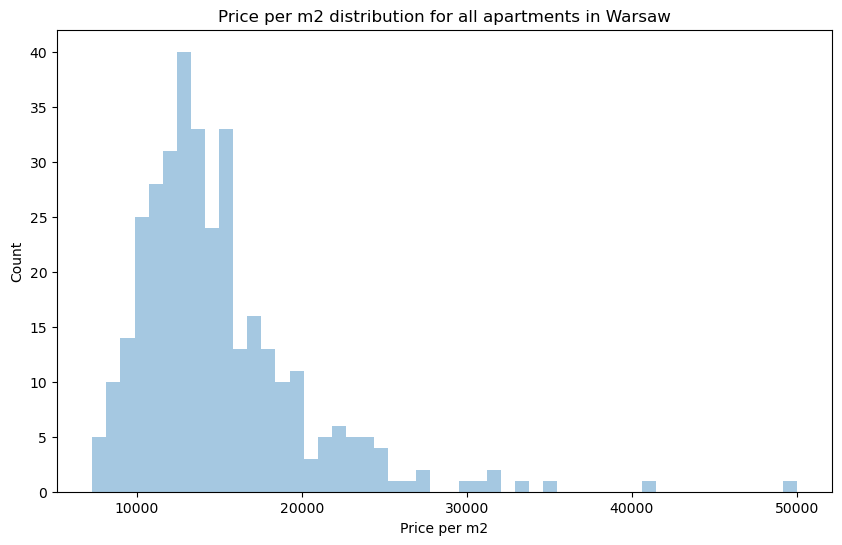

In [191]:
# plot price per m2 distribution for all apartments in Warsaw 
plt.figure(figsize=(10, 6))
sns.distplot(insights['price_per_m2'], bins=50, kde=False)
plt.title('Price per m2 distribution for all apartments in Warsaw')
plt.xlabel('Price per m2')
plt.ylabel('Count')
plt.show()

C:\Users\mi.martowicz\AppData\Local\Temp\ipykernel_1676\946159346.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(insights['price'], bins=50, kde=False)


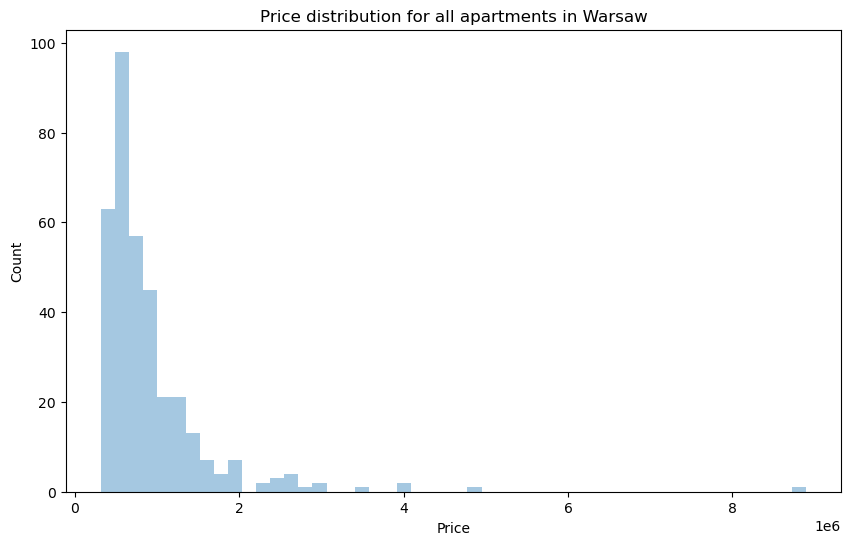

In [169]:
# plot price for all apartments in Warsaw and show price true values on xlabel
plt.figure(figsize=(10, 6))
sns.distplot(insights['price'], bins=50, kde=False)
plt.title('Price distribution for all apartments in Warsaw')
plt.xlabel('Price')
plt.ylabel('Count')
plt.show()


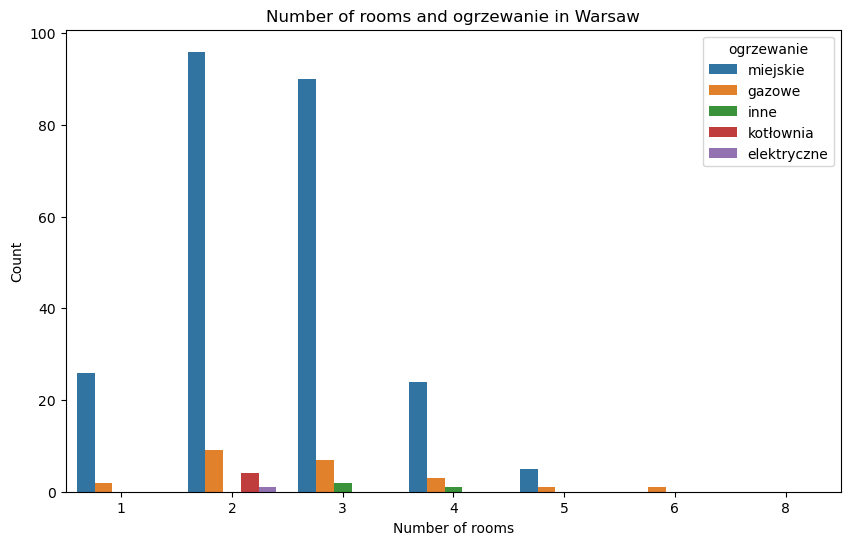

In [171]:
# compare number of rooms and ogrzewanie in Warsaw
plt.figure(figsize=(10, 6))
sns.countplot(x='rooms', hue='ogrzewanie', data=insights)
plt.title('Number of rooms and ogrzewanie in Warsaw')
plt.xlabel('Number of rooms')
plt.ylabel('Count')
plt.show()